In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, roc_auc_score, roc_curve

In [2]:
# Paths to dataset directories
train_dir = "Training"  
test_dir = "Testing"   

# Parameters
img_size = 224
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Class info
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 4800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [3]:
# Load ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True  # Fine-tune all layers

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Compile
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [4]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
callbacks = [early_stop, lr_reduce]

In [5]:
history_resnet50 = model_resnet50.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=callbacks
)

# Save model
model_resnet50.save("resnet50_model.h5")

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1061s 7s/step - accuracy: 0.7924 - loss: 0.5632 - val_accuracy: 0.2500 - val_loss: 15.4309 - learning_rate: 1.0000e-04
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1048s 7s/step - accuracy: 0.9465 - loss: 0.1504 - val_accuracy: 0.3033 - val_loss: 1.5885 - learning_rate: 1.0000e-04
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1033s 7s/step - accuracy: 0.9563 - loss: 0.1303 - val_accuracy: 0.2567 - val_loss: 2.1182 - learning_rate: 1.0000e-04
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1070s 7s/step - accuracy: 0.9594 - loss: 0.1103 - val_accuracy: 0.2850 - val_loss: 3.0439 - learning_rate: 1.0000e-04
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1049s 7s/step - accuracy: 0.9746 - loss: 0.0851 - val_accuracy: 0.3958 - val_loss: 2.3916 - learning_rate: 2.0000e-05


In [9]:
# Save the trained ResNet50 model with custom filename
model_resnet50.save("Resnet50_brain_tumor.h5")

In [6]:
# Evaluate
loss, acc = model_resnet50.evaluate(test_generator)
y_pred = np.argmax(model_resnet50.predict(test_generator), axis=1)
y_true = test_generator.classes
y_probs = model_resnet50.predict(test_generator)

print(f"ResNet50 Accuracy: {acc:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.2552 - loss: 1.4677
38/38 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step
ResNet50 Accuracy: 0.3033


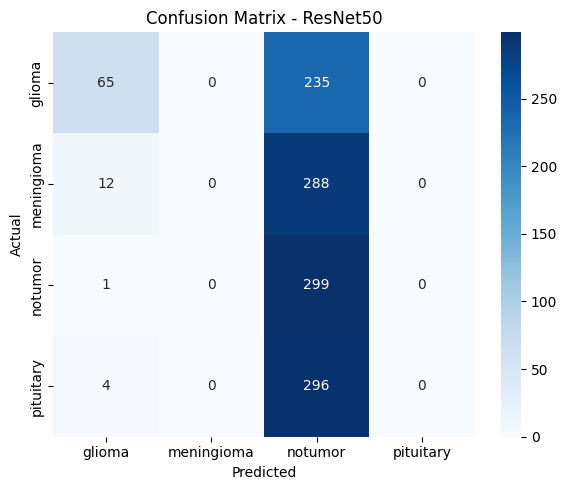

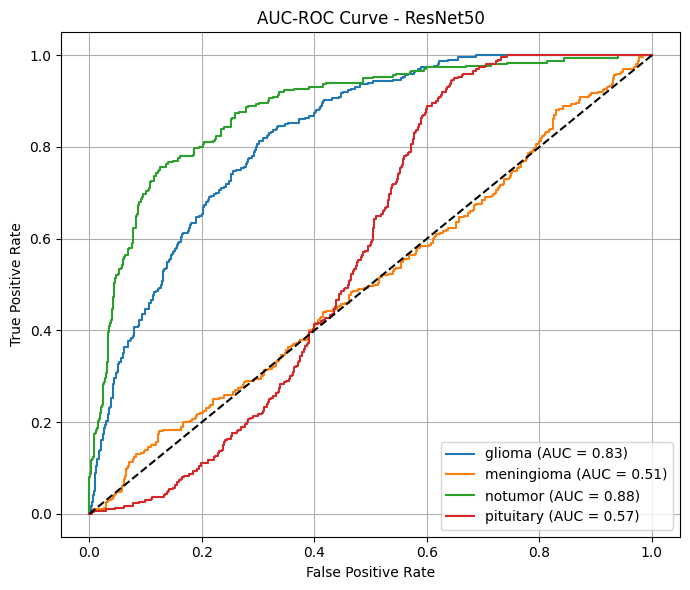

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# AUC-ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_generator.labels == i, y_probs[:, i])
    roc_auc[i] = roc_auc_score(test_generator.labels == i, y_probs[:, i])

plt.figure(figsize=(7, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve - ResNet50")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Classification Report & Metrics
cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
mcm = multilabel_confusion_matrix(y_true, y_pred)
tp = mcm[:, 1, 1].sum()
tn = mcm[:, 0, 0].sum()
fp = mcm[:, 0, 1].sum()
fn = mcm[:, 1, 0].sum()
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

model_results = {
    "Model": ["ResNet50"],
    "Accuracy": [acc],
    "Precision": [cr["macro avg"]["precision"]],
    "Recall": [cr["macro avg"]["recall"]],
    "Specificity": [specificity],
    "F1-Score": [cr["macro avg"]["f1-score"]],
    "TP": [tp],
    "TN": [tn],
    "FP": [fp],
    "FN": [fn]
}

results_df = pd.DataFrame(model_results)
csv_file = "all_model_results.csv"

if os.path.exists(csv_file):
    results_df.to_csv(csv_file, mode='a', header=False, index=False)
else:
    results_df.to_csv(csv_file, index=False)

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Found 1200 images belonging to 4 classes.


C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step


C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

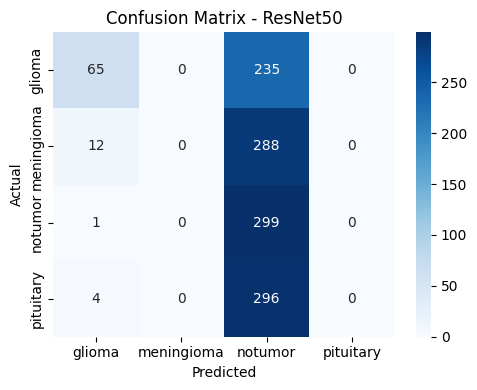

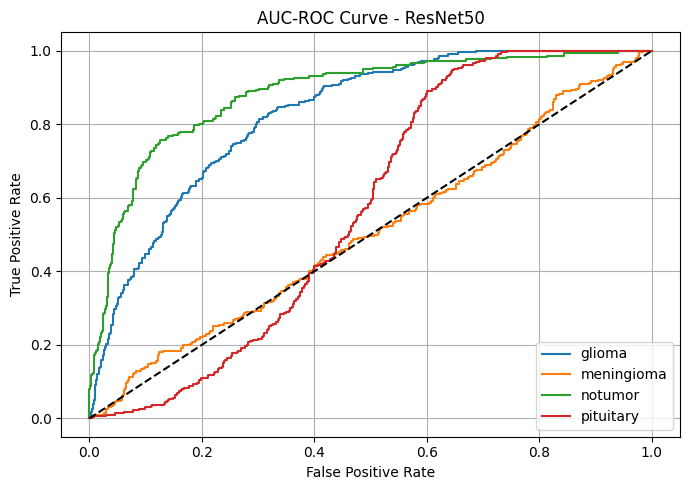

In [1]:
# Required imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, multilabel_confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the model
model_resnet50 = load_model("Resnet50_brain_tumor.h5")

# Prepare test data again (ensure paths are correct)
img_size = 224
batch_size = 32
test_dir = "Testing" 

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

# Get predictions
y_true = test_generator.classes
y_pred_probs = model_resnet50.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix & Classification Report
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
mcm = multilabel_confusion_matrix(y_true, y_pred)
tp = mcm[:, 1, 1].sum()
tn = mcm[:, 0, 0].sum()
fp = mcm[:, 0, 1].sum()
fn = mcm[:, 1, 0].sum()
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

# Accuracy
loss, acc = model_resnet50.evaluate(test_generator, verbose=0)

# AUC-ROC (macro-average)
try:
    auc_roc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
except:
    auc_roc = 0.0

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot AUC-ROC Curve
fpr = {}
tpr = {}
plt.figure(figsize=(7, 5))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_generator.labels == i, y_pred_probs[:, i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve - ResNet50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Results to CSV
model_results = {
    "Model": ["ResNet50"],
    "Accuracy": [acc],
    "Precision": [cr['macro avg']['precision']],
    "Recall": [cr['macro avg']['recall']],
    "Specificity": [specificity],
    "F1-Score": [cr['macro avg']['f1-score']],
    "AUC-ROC": [auc_roc],
    "TP": [tp],
    "TN": [tn],
    "FP": [fp],
    "FN": [fn]
}

results_df = pd.DataFrame(model_results)
results_file = "all_model_results.csv"

# Append or create results CSV
if os.path.exists(results_file):
    results_df.to_csv(results_file, mode='a', index=False, header=False)
else:
    results_df.to_csv(results_file, index=False)